In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import time
import seaborn as sns
import folium
import folium.plugins as plugins
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

### data preprocessing

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

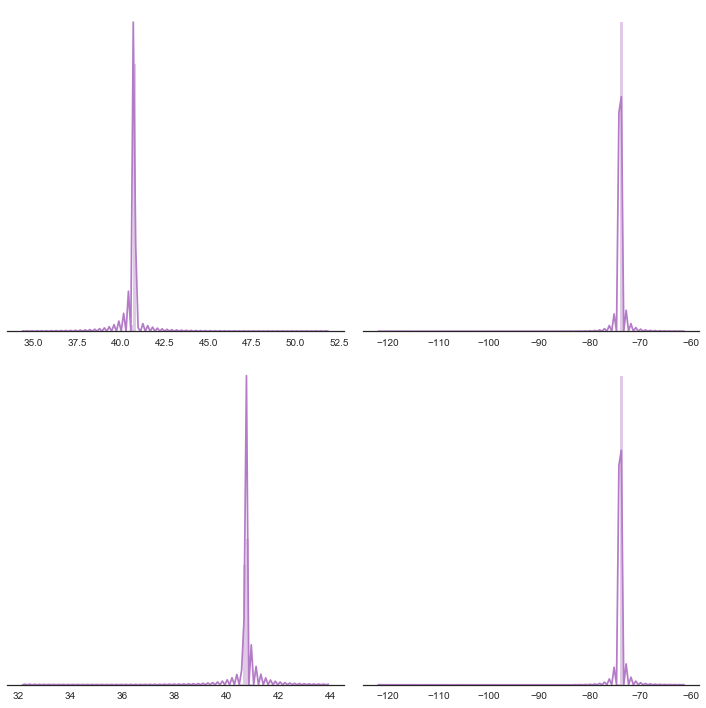

In [4]:
# seaborn sns
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(train['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train['pickup_longitude'].values, label = 'pickup_longitude',color="m",bins =100, ax=axes[0,1])
sns.distplot(train['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train['dropoff_longitude'].values, label = 'dropoff_longitude',color="m",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

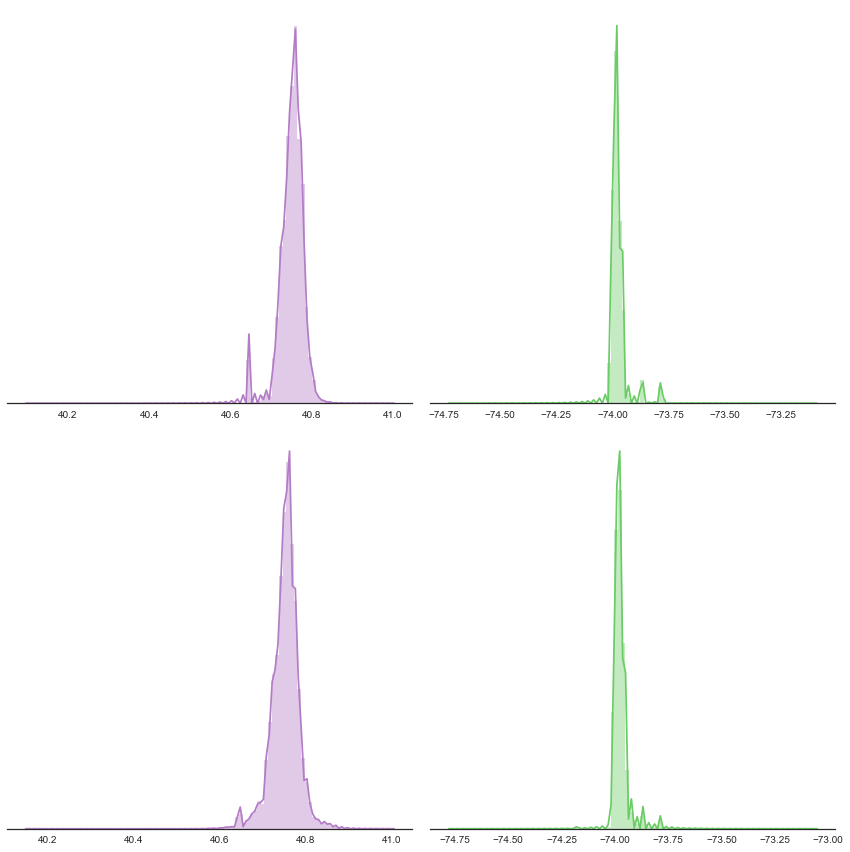

In [5]:
train = train.loc[(train.pickup_latitude > 40) & (train.pickup_latitude < 41)]
train = train.loc[(train.dropoff_latitude>40) & (train.dropoff_latitude < 41)]
train = train.loc[(train.dropoff_longitude > -75.5) & (train.dropoff_longitude < -73)]
train = train.loc[(train.pickup_longitude > -75.5) & (train.pickup_longitude < -73)]
train_data_new = train.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(12, 12), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(train_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="g",bins =100, ax=axes[0,1])
sns.distplot(train_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="g",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

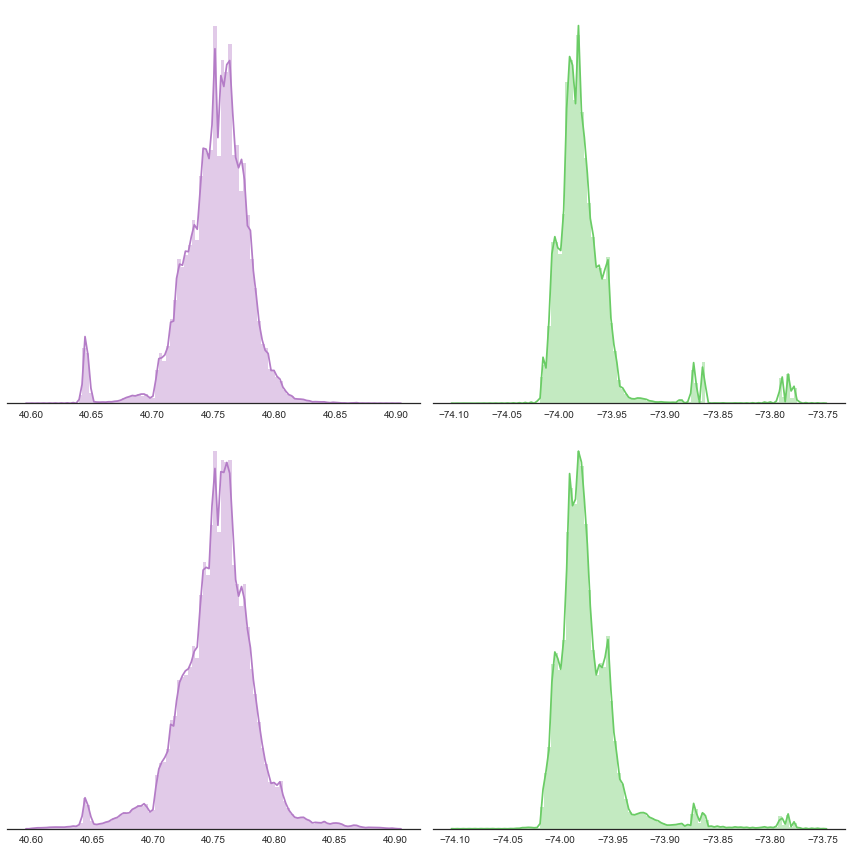

In [6]:
train = train.loc[(train.pickup_latitude > 40.6) & (train.pickup_latitude < 40.9)]
train = train.loc[(train.dropoff_latitude>40.6) & (train.dropoff_latitude < 40.9)]
train = train.loc[(train.dropoff_longitude > -74.10) & (train.dropoff_longitude < -73.75)]
train = train.loc[(train.pickup_longitude > -74.10) & (train.pickup_longitude < -73.75)]
train_data_new = train.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(12, 12), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(train_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="g",bins =100, ax=axes[0,1])
sns.distplot(train_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="g",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

In [7]:
train = train[train.passenger_count > 0]

In [8]:
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['dropoff_hour'] = pd.DatetimeIndex(train['dropoff_datetime']).hour
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['pickup_hour'] = pd.DatetimeIndex(train['pickup_datetime']).hour
total_rows = len(train.index)

/Users/zhefeng/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


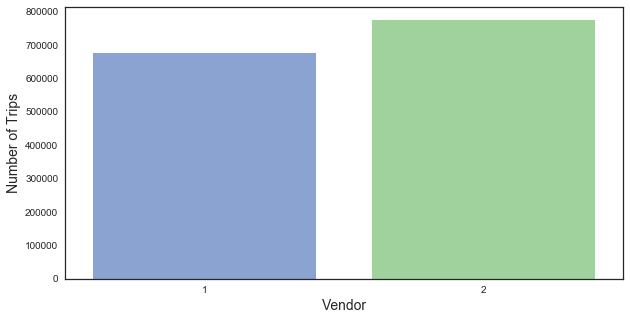

In [9]:
unique_vendors = set(train['vendor_id'].values)
vendor_popularity = train['vendor_id'].value_counts()

f = plt.figure(figsize=(10,5))
sns.barplot(vendor_popularity.index, vendor_popularity.values, alpha=0.7)
plt.xlabel('Vendor', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.show()

Maximum number of passengers on a trip :  8
Minimum number of passengers on a trip :  1
Average number of passengers on a trip :  1.6641392522339369


/Users/zhefeng/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


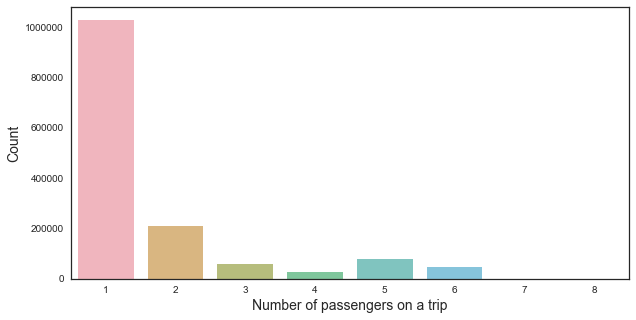

In [10]:
# Moving to passengers count column
pass_count = train['passenger_count']
print("Maximum number of passengers on a trip : ", np.max(pass_count.values))
print("Minimum number of passengers on a trip : ", np.min(pass_count.values))
print("Average number of passengers on a trip : ", np.mean(pass_count.values))

f = plt.figure(figsize=(10,5))
pass_count = train['passenger_count'].value_counts()
sns.barplot(pass_count.index, pass_count.values, alpha=0.7)
plt.xlabel('Number of passengers on a trip', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

/Users/zhefeng/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


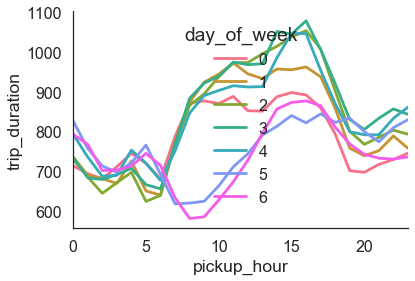

In [11]:
train.loc[:, 'week_of_year'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'day_of_year'] = train['pickup_datetime'].dt.dayofyear
train.loc[:, 'day_of_week'] = train['pickup_datetime'].dt.dayofweek
summary_hour_duration = pd.DataFrame(train.groupby(['day_of_week','pickup_hour'])['trip_duration'].mean())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_hour_duration, time="pickup_hour", unit = "unit", condition="day_of_week", value="trip_duration")
sns.despine(bottom = False)

In [12]:
temp = train.copy()
train.loc[:, 'pick_date'] = train['pickup_datetime'].dt.date

ts_v1 = pd.DataFrame(train.loc[train['vendor_id']==1].groupby('pick_date')['trip_duration'].mean())
ts_v1.reset_index(inplace = True)
ts_v2 = pd.DataFrame(train.loc[train.vendor_id==2].groupby('pick_date')['trip_duration'].mean())
ts_v2.reset_index(inplace = True)

# use BokehJS
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
output_notebook()
p = figure(plot_width=800, plot_height=250, x_axis_type="datetime")
p.title.text = 'Yearly Trip Duration Distribution for different days of the year'

for data, name, color in zip([ts_v1, ts_v2], ["vendor 1", "vendor 2"], Spectral4):
    df = data
    p.line(df['pick_date'], df['trip_duration'], line_width=2, color=color, alpha=0.8, legend=name)

p.legend.location = "top_left"
p.legend.click_policy="hide"
show(p)
train = temp

Loading BokehJS ...

/Users/zhefeng/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


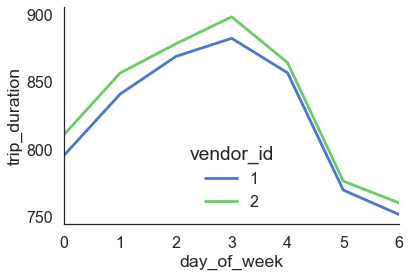

In [13]:
train.loc[:, 'day_of_week'] = train['pickup_datetime'].dt.dayofweek
summary_wdays_avg_duration = pd.DataFrame(train.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)

/Users/zhefeng/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


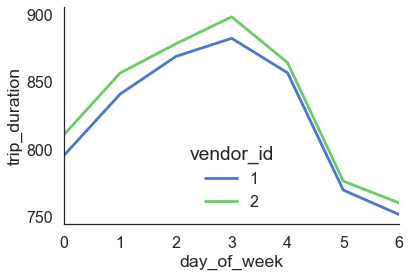

In [14]:
train.loc[:, 'day_of_week'] = train['pickup_datetime'].dt.dayofweek
summary_wdays_avg_duration = pd.DataFrame(train.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)

### Model training

In [15]:
train ,test = train_test_split(train,test_size=0.3)
train.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
734362   id2211628          1 2016-01-17 16:54:10 2016-01-17 17:26:59   
552895   id2932425          1 2016-02-24 16:39:40 2016-02-24 16:55:19   
349897   id2049001          1 2016-01-25 00:27:24 2016-01-25 00:37:04   
705814   id2605355          2 2016-04-11 16:08:15 2016-04-11 16:13:58   
1323270  id2891717          1 2016-02-14 11:10:38 2016-02-14 11:14:35   

         passenger_count  pickup_longitude  pickup_latitude  \
734362                 1        -73.980972        40.784523   
552895                 2        -74.006538        40.732311   
349897                 1        -73.966751        40.761322   
705814                 1        -73.976738        40.775169   
1323270                1        -73.945724        40.777946   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
734362          -74.013771         40.711315                  N   
552895          -73.986801         40.736801                  N   
349897          -73.919167         40.754753                  N   
705814          -73.981949         40.765480                  N   
1323270         -73.955254         40.768345                  N   

         trip_duration  dropoff_hour  pickup_hour  week_of_year  day_of_year  \
734362            1969            17           16             2           17   
552895             939            16           16             8           55   
349897             580             0            0             4           25   
705814             343            16           16            15          102   
1323270            237            11           11             6           45   

         day_of_week  
734362             6  
552895             2  
349897             0  
705814             0  
1323270            6

In [16]:
print (type(train))

<class 'pandas.core.frame.DataFrame'>


In [17]:
train_new = train.as_matrix()

In [18]:
def get_X_y(df):
    X = df.drop(['id','trip_duration','store_and_fwd_flag'], axis = 1)
    y = df['trip_duration']
    return X, y

In [19]:
train_X, train_y = get_X_y(train)
test_X, test_y = get_X_y(test)

In [20]:
type(train_X)

pandas.core.frame.DataFrame

In [21]:
type(train_y)

pandas.core.series.Series

In [22]:
train_X = train_X.as_matrix()
train_y = train_y.as_matrix()

In [23]:
train_X[0]

array([1, Timestamp('2016-01-17 16:54:10'),
       Timestamp('2016-01-17 17:26:59'), 1, -73.98097229003906,
       40.784523010253906, -74.0137710571289, 40.7113151550293, 17, 16, 2,
       17, 6], dtype=object)

In [24]:
def datetime_to_float(m):
    for i in range(len(m)):
        m[i][1] = m[i][1].timestamp()
        m[i][2] = m[i][2].timestamp()

In [25]:
datetime_to_float(train_X)

In [26]:
train_X[0]

array([1, 1453049650.0, 1453051619.0, 1, -73.98097229003906,
       40.784523010253906, -74.0137710571289, 40.7113151550293, 17, 16, 2,
       17, 6], dtype=object)

In [27]:
test_X = test_X.as_matrix()
test_y = test_y.as_matrix()

In [28]:
test_X[0]

array([1, Timestamp('2016-06-29 07:12:33'),
       Timestamp('2016-06-29 07:20:24'), 1, -73.98707580566406,
       40.75075912475585, -73.97293853759766, 40.74522018432617, 7, 7, 26,
       181, 2], dtype=object)

In [29]:
datetime_to_float(test_X)

In [30]:
test_X[0]

array([1, 1467184353.0, 1467184824.0, 1, -73.98707580566406,
       40.75075912475585, -73.97293853759766, 40.74522018432617, 7, 7, 26,
       181, 2], dtype=object)

#### ridge regression

In [31]:
rd = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='sag', tol=0.001)
rd.fit(train_X, train_y)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='sag', tol=0.001)

In [33]:
rd.score(test_X, test_y)

0.8658653892170827

In [34]:
rd_score3 = cross_val_score(rd,test_X,test_y,cv=3)
print (rd_score3)

[0.55359205 0.55121869 0.5510197 ]


In [35]:
rd_score5 = cross_val_score(rd,test_X,test_y,cv=5)
print (rd_score5)

[0.60645049 0.60460389 0.60577214 0.60478398 0.60545398]


In [36]:
rd_score10 = cross_val_score(rd,test_X,test_y,cv=10)
print (rd_score10)

[0.64007993 0.64054084 0.63996662 0.63852868 0.64054771 0.6393527
 0.63950097 0.63899812 0.64046298 0.63916275]


In [37]:
rd = Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='sag', tol=0.001)
rd.fit(train_X, train_y)
rd.score(test_X, test_y)

0.8658617827005168

In [38]:
rd = Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='sag', tol=0.001)
rd.fit(train_X, train_y)
rd.score(test_X, test_y)

0.8658609487273476

In [39]:
rd = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
rd.fit(train_X, train_y)

/Users/zhefeng/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.490247613595545e-18 / 1.1102230246251565e-16
  RuntimeWarning)


Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [40]:
rd.score(test_X, test_y)

0.9999999999999799

In [41]:
rd = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='svd', tol=0.001)
rd.fit(train_X, train_y)
rd.score(test_X, test_y)

1.0

In [42]:
rd = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='cholesky', tol=0.001)
rd.fit(train_X, train_y)
rd.score(test_X, test_y)

/Users/zhefeng/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.490247613595545e-18 / 1.1102230246251565e-16
  RuntimeWarning)


0.9999999999999799

In [43]:
rd = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='lsqr', tol=0.001)
rd.fit(train_X, train_y)
rd.score(test_X, test_y)

0.003767450583948339

In [44]:
rd = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='sparse_cg', tol=0.001)
rd.fit(train_X, train_y)
rd.score(test_X, test_y)

0.9999999998266498

In [45]:
rd = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='saga', tol=0.001)
rd.fit(train_X, train_y)
rd.score(test_X, test_y)

0.7120465064116319

In [46]:
rd = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10,
      normalize=False, random_state=None, solver='sag', tol=0.001)
rd.fit(train_X, train_y)
rd.score(test_X, test_y)

/Users/zhefeng/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


-0.04015213371835946

In [47]:
rd = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=20,
      normalize=False, random_state=None, solver='sag', tol=0.001)
rd.fit(train_X, train_y)
rd.score(test_X, test_y)

/Users/zhefeng/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.06939523167242845

In [49]:
rd = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=40,
      normalize=False, random_state=None, solver='sag', tol=0.001)
rd.fit(train_X, train_y)
rd.score(test_X, test_y)

/Users/zhefeng/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.13182720793374714

In [50]:
rd = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=80,
      normalize=False, random_state=None, solver='sag', tol=0.001)
rd.fit(train_X, train_y)
rd.score(test_X, test_y)

/Users/zhefeng/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.24337825268270574

In [51]:
rd = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=100,
      normalize=False, random_state=None, solver='sag', tol=0.001)
rd.fit(train_X, train_y)
rd.score(test_X, test_y)

/Users/zhefeng/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.29368376045244104

In [52]:
rd = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, random_state=None, solver='sag', tol=0.001)
rd.fit(train_X, train_y)
rd.score(test_X, test_y)

0.8658639260563201

In [53]:
rd = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=500,
      normalize=False, random_state=None, solver='sag', tol=0.001)
rd.fit(train_X, train_y)
rd.score(test_X, test_y)

/Users/zhefeng/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.8215482737896265

In [60]:
from math import sqrt
def rmse(true, pred):
    return sqrt(mean_squared_error(true, pred))

In [61]:
rmse(train_y, rd.predict(train_X))

274.9711219344063